# Introduction

We want some sense of what's in the genes differentially expressed between alevin & kallisto/bustools, and i haven't tried GO analyses before.... So lets see what we can get working.

I finally have something sharable using the protein coding focused minimal set.

Starting with the 10x 10.5 dataset, I selected all the genes that were greater than 10 counts in one algorithm and were zero in the other.

(I also did > 1 in one algorithm and 0 expression in the other, but that was around 10 thousand genes)

I counted in how many cells those genes met those criteria, though I just added the cell to the list if it showed up at least once for the algorithm. Since the > 10 counts threshold was already pretty strict.

Since it was possible for one gene to be in both lists for the Gene Ontology Enrichment analysis I split it into lists of genes that were in one algorithm or the other, or in both.

I put everything into one excel sheet.

The first 3 sheets are the gene lists with Ensembl gene IDs, gene name, gene type, and the unversioned gene IDs since when I tried DAVID it didn't like the Ensembl IDs with versions.

The second 3 sets are the output of "Goatools" a python gene ontology tool I found with google
https://www.nature.com/articles/s41598-018-28948-z
There example i followed included a .05 FDR threshold.

For the background of genes it wanted I used genes that were expressed in at least 5% of the cells. 

It didn't find anything in particular for Kallisto's expressed genes.

BH_FDR stands for "fdr correction with Benjamini/Hochberg (non-negative)"

In [1]:
import scanpy
import goatools
import pandas
import numpy
import seaborn
from collections import Counter
from xopen import xopen
from matplotlib import pyplot, cm, colors
from pathlib import Path
import sys

In [2]:
%matplotlib notebook

In [3]:
LRSC = str(Path('~/proj/long-rna-seq-condor').expanduser())
if LRSC not in sys.path:
    sys.path.append(LRSC)
from woldrnaseq.madqc import compute_all_vs_all_scores, replicate_scores
from woldrnaseq.plot_genes_detected import bin_library_quantification, plot_gene_detection_histogram

In [4]:
mm10_basic_store = pandas.HDFStore(Path('~/proj/genome/mm10-M21_basic-male/mm10-M21_basic-male.h5').expanduser())
mm10_basic = mm10_basic_store[list(mm10_basic_store.keys())[0]]
mm10_basic_store.close()


mm10_basic['feature_length'] = mm10_basic['stop'] - mm10_basic['start']

transcript_lengths = mm10_basic[mm10_basic['type'].isin(('exon', 'tRNA'))].groupby('transcript_id')['feature_length'].sum().to_dict()
mm10_basic['transcript_length'] = mm10_basic[mm10_basic['type'].isin(('transcript', 'tRNA')) | (mm10_basic['source'] == 'spikein')]['transcript_id'].apply(lambda transcript_id: transcript_lengths.get(transcript_id, numpy.nan))

gene_lengths = mm10_basic.groupby('gene_id')['transcript_length'].max().to_dict()
mm10_basic['max_transcript_length'] = mm10_basic[mm10_basic['type'].isin(('gene', 'tRNA'))| (mm10_basic['source'] == 'spikein')]['gene_id'].apply(lambda gene_id: gene_lengths.get(gene_id, numpy.nan))

isoform_count = mm10_basic[mm10_basic['type'] == 'transcript'][['gene_id', 'transcript_id']].groupby('gene_id').count()['transcript_id'].to_dict()
mm10_basic['isoform_count'] = mm10_basic['gene_id'].apply(lambda x: isoform_count.get(x, 1))

In [5]:
pandas.options.display.max_rows = 150

In [6]:
from goatools.base import download_go_basic_obo
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


In [7]:
from goatools.base import download_ncbi_associations
file_gene2go = download_ncbi_associations()

  EXISTS: gene2go


In [8]:
from goatools.obo_parser import GODag

obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2021-01-01) 47,285 GO Terms


In [9]:
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.anno.init.reader_genetogo import InitAssc, timeit, cx
import datetime

class EnsemblInitAssc(InitAssc):
    def init_associations(self, fin_anno, taxids=None, namespaces=None):
        """Read annotation file. Store annotation data in a list of namedtuples."""
        nts = []
        if fin_anno is None:
            return nts
        tic = timeit.default_timer()
        lnum = -1
        line = "\t"*len(self.flds)
        cnts = {'taxids':set(), 'genes':set(), 'goids':set()}
        try:
            with open(fin_anno) as ifstrm:
                category2ns = {'Process':'BP', 'Function':'MF', 'Component':'CC'}
                ntobj = cx.namedtuple('ntanno', self.flds)
                # Get: 1) Specified taxids, default taxid(human), or all taxids
                get_all_taxids = taxids is True
                get_all_nss = namespaces is None or namespaces == {'BP', 'MF', 'CC'}
                taxids = self.taxids
                for lnum, line in enumerate(ifstrm, 1):
                    # Read data
                    if line[0] != '#':
                        vals = line.split('\t')
                        taxid = int(vals[0])
                        nspc = category2ns[vals[7].rstrip()]
                        if (get_all_taxids or taxid in taxids) and (get_all_nss or nspc in namespaces):
                            # assert len(vals) == 8
                            cnts['taxids'].add(taxid)
                            geneid = vals[1]
                            cnts['genes'].add(geneid)
                            goid = vals[2]
                            cnts['goids'].add(goid)
                            ntd = ntobj(
                                tax_id=taxid,
                                DB_ID=geneid,
                                GO_ID=goid,
                                Evidence_Code=vals[3],
                                Qualifier=self._get_qualifiers(vals[4]),
                                GO_term=vals[5],
                                DB_Reference=self._get_pmids(vals[6]),
                                NS=nspc)
                            #self._chk_qualifiers(qualifiers, lnum, ntd)
                            nts.append(ntd)
                    # Read header
                    elif line[0] == '#':
                        assert line[1:-1].split('\t') == self.hdrs
        # pylint: disable=broad-except
        except Exception as inst:
            import traceback
            traceback.print_exc()
            sys.stderr.write("\n  **FATAL: {MSG}\n\n".format(MSG=str(inst)))
            sys.stderr.write("**FATAL: {FIN}[{LNUM}]:\n{L}".format(FIN=fin_anno, L=line, LNUM=lnum))
            self._prt_line_detail(sys.stdout, line, lnum)
            sys.exit(1)
        print('HMS:{HMS} {N:7,} annotations, {G:6,} genes, {GOs:6,} GOs, {T} taxids READ: {ANNO} {NSs}'.format(
            N=len(nts), ANNO=fin_anno,
            G=len(cnts['genes']), GOs=len(cnts['goids']), T=len(cnts['taxids']),
            ## N=len(nts), ANNO=fin_anno, G=-1, T=-1,
            NSs=','.join(namespaces) if namespaces else '',
            HMS=str(datetime.timedelta(seconds=(timeit.default_timer()-tic)))))
        return nts

class EnsemblGene2GoReader(Gene2GoReader):
    @staticmethod
    def _init_associations(fin_anno, taxid=None, taxids=None, namespaces=None, **kws):
        """Read annotation file and store a list of namedtuples."""
        return EnsemblInitAssc(taxid, taxids).init_associations(fin_anno, taxids, namespaces)
    

In [10]:
# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = EnsemblGene2GoReader('ensembl_gene2go', taxids=[10090])

# Get associations for each branch of the GO DAG (BP, MF, CC)
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))

HMS:0:00:06.311096 930,750 annotations, 22,303 genes, 18,642 GOs, 1 taxids READ: ensembl_gene2go 
CC 19,950 annotated mouse genes
MF 18,553 annotated mouse genes
BP 19,055 annotated mouse genes


In [11]:
cells = ['CTGCGGATCGCTTAGA', 'GCTCTGTGTCTAGCGC', 'CGATGTACACCAGCAC']

In [12]:
cellranger_name = "Cell Ranger"
star_name = "STAR Solo"
alevin_name = "Salmon Alevin (EM)"
alevin_decoy_name = "Salmon Alevin Decoy (EM)"
kallisto_name = "Kallisto"
kallisto_em_name = "Kallisto (EM)"

In [13]:
tenx_datasets = {
    #cellranger_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/cellranger_filtered.h5ad').to_df().T,
    star_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/solo_filtered.h5ad').to_df().T,
    alevin_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin.h5ad').to_df().T,
    alevin_decoy_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/alevin_decoy.h5ad').to_df().T,    
    kallisto_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_filtered.h5ad').to_df().T,
    kallisto_em_name: scanpy.read_h5ad('ENCSR874BOF_e10_5_minimal_limb/kallisto_em_filtered.h5ad').to_df().T,
}

In [14]:
def score_terms(uniprot_map, gene_ids):
    goterms = Counter()
    for row in uniprot_map[uniprot_map['Ensembl'].isin(gene_ids)]['GO']:
        # do we need to check of there are duplicates in a row?
        if not pandas.isnull(row):
            for go in row.split(';'):
                goterms[go.strip()] += 1
    return goterms

def get_base_gene_ids(versioned_gene_ids):
    return [x.split('.')[0] for x in versioned_gene_ids]

def find_expressed_gene_ids(left, right, threshold=0):
    filtered = (left > threshold) & (right == 0)
    
    return left[filtered].index
    #left_ids = get_base_gene_ids(left[filtered].index)
    #return left_ids

def find_go_terms_expressed(left, right, uniprot_map, threshold=0):
    filtered = (left > threshold) & (right <= threshold)
    
    left_ids = get_base_gene_ids(left[filtered].index)
    left_terms = score_terms(uniprot_map, left_ids)

    return left_terms

In [15]:
#left_terms = find_go_terms_expressed(tenx_datasets[kallisto_em_name][cells[1]], tenx_datasets[alevin_decoy_name][cells[1]], id_map)
#right_terms = find_go_terms_expressed(tenx_datasets[alevin_decoy_name][cells[1]],tenx_datasets[kallisto_em_name][cells[1]], id_map)
#print(len(left_terms), len(right_terms))

In [16]:
#{k: left_terms[k] for k in left_terms if left_terms[k] > 100}

In [17]:
#{k: right_terms[k] for k in right_terms if right_terms[k] > 100}

In [18]:
#print("\n".join(list(find_expressed_gene_ids(tenx_datasets[kallisto_em_name][cells[1]], tenx_datasets[alevin_decoy_name][cells[1]], df))))

In [19]:
#print("\n".join(list(find_expressed_gene_ids(tenx_datasets[alevin_decoy_name][cells[1]], tenx_datasets[kallisto_em_name][cells[1]], df))))

In [20]:
def count_expressed_in_one(tenx_datasets, threshold):
    frequency = {}

    for alg_x in tenx_datasets:
        for alg_y in tenx_datasets:
            if alg_x != alg_y:
                frequency.setdefault(alg_x, {}).setdefault(alg_y, Counter())
                for cell_id in tenx_datasets[alg_x]:
                    column_x = tenx_datasets[alg_x]
                    column_y = tenx_datasets[alg_y]
                    for gene_id in find_expressed_gene_ids(column_x, column_y, threshold):
                         frequency[alg_x][alg_y][gene_id] += 1
            
    return frequency

# this didn't work so well.

In [21]:
def count_expressed_in_only_one(tenx_dataests, left_name, right_name, threshold):
    left_expressed = Counter()
    right_expressed = Counter()
    for cell_id in tenx_datasets[left_name]:
        left_column = tenx_datasets[left_name][cell_id]
        right_column = tenx_datasets[right_name][cell_id]
        for gene_id in find_expressed_gene_ids(left_column, right_column, threshold):
            left_expressed[gene_id] += 1
        for gene_id in find_expressed_gene_ids(right_column, left_column, threshold):
            right_expressed[gene_id] += 1

    print("Expressed in just", left_name, len(left_expressed))
    print("Expressed in just", right_name, len(right_expressed))
    print("Somtimes expressed in either (intersect)", len(set(left_expressed).intersection(right_expressed)))
    print("All genes (union)", len(set(left_expressed).union(right_expressed)))
    return pandas.DataFrame({left_name: left_expressed, right_name: right_expressed})

In [22]:
def plot_expressed_in_one(datasets, left_name, right_name, threshold, gtf):
    frequency = count_expressed_in_only_one(datasets, left_name, right_name, threshold)
    
    left_expressed = frequency[left_name][(frequency[left_name] > 0)]
    right_expressed = frequency[right_name][(frequency[right_name] > 0)]
    expressed_union = set(left_expressed.index).union(right_expressed.index)

    for name in [left_name, right_name]:
        frequency['{} median expressed count'.format(name)] = tenx_datasets[name].loc[expressed_union].median(axis=1)
    
    print(frequency.columns)
    f = pyplot.figure(figsize=(12,4))
    ax = f.add_subplot(1,3,1)
    ax.set_title(f'{left_name} > {threshold}\n{right_name}=0\n{left_name} color')
    r = frequency.plot.scatter(x=left_name, y=right_name, c=f'{left_name} median expressed count', cmap='viridis', ax=ax)
    #r.set_ylabel(f"{left_name} counts")
    ax.set_ylabel(f'{right_name}\nnumber of cells expressed')
    ax.set_xlabel(f'{left_name}\nnumber of cells expressed')

    ax = f.add_subplot(1,3,2)
    ax.set_title(f'{left_name} > {threshold}\n{right_name}=0\n{right_name} color')
    r = frequency.plot.scatter(x=left_name, y=right_name, c=f'{right_name} median expressed count', cmap='viridis', ax=ax)
    ax.set_ylabel(f'{right_name}\nnumber of cells expressed')
    ax.set_xlabel(f'{left_name}\nnumber of cells expressed')
    
    gene_like = ((gtf['type'].isin(('gene', 'tRNA')))|(gtf['source'] == 'spikein'))
    is_expressed = (gtf['gene_id'].isin(expressed_union))
    transcript_length = gtf[is_expressed & gene_like].set_index('gene_id')[['max_transcript_length']]
    ##print(transcript_length.head())
    frequency = frequency.merge(transcript_length['max_transcript_length'], left_index=True, right_index=True)
    #print(frequency.head())
    viridis = cm.get_cmap('viridis')
    transcript_norm=colors.LogNorm(
        vmin=transcript_length.min(), 
        vmax=20_000  #transcript_length.max()
    )
    #transcript_colors = [viridis(transcript_norm(x)) for x in transcript_length]
    frequency['max_transcript_length_color'] = frequency['max_transcript_length'].apply(transcript_norm)
    #print('frequency', frequency.shape)
    ax = f.add_subplot(1,3,3)
    ax.set_title(f'{left_name} > {threshold}\n{right_name}=0\ntranscript length color')
    #r = frequency.plot.scatter(x=left_name, y=right_name, c='max_transcript_length_color', cmap='viridis', ax=ax)
    r = ax.scatter(
        x=frequency[left_name],
        y=frequency[right_name],
        c=frequency['max_transcript_length'],
        cmap=viridis,
        vmax=20000,
    )
    ax.set_xlabel(f'{left_name}\nnumber of cells expressed')    
    ax.set_ylabel(f'{right_name}\nnumber of cells expressed')
    cb = f.colorbar(r, ax=ax)
    cb.ax.set_ylabel("transcript length (capped at 20,000 bp)")
    f.tight_layout()
    return f

Expressed in just Kallisto (EM) 13091
Expressed in just Salmon Alevin Decoy (EM) 7915
Somtimes expressed in either (intersect) 6911
All genes (union) 14095
Index(['Kallisto (EM)', 'Salmon Alevin Decoy (EM)',
       'Kallisto (EM) median expressed count',
       'Salmon Alevin Decoy (EM) median expressed count'],
      dtype='object')


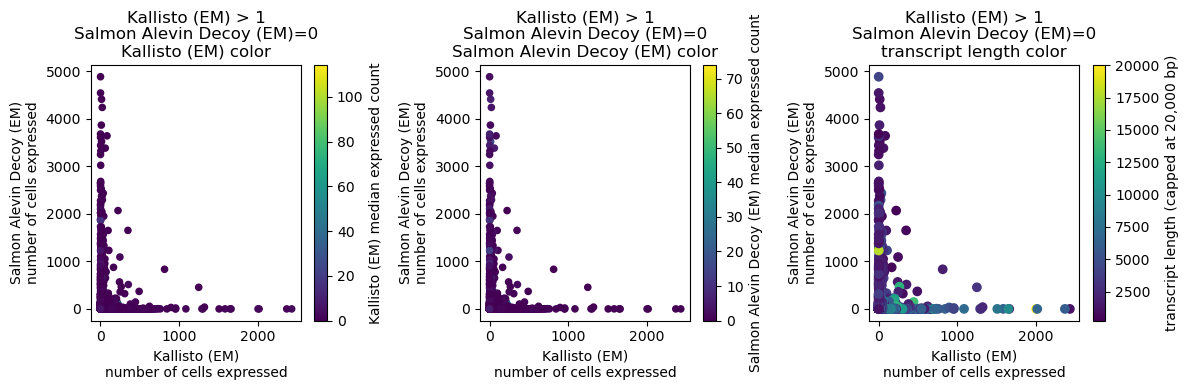

In [135]:
_ = plot_expressed_in_one(tenx_datasets, kallisto_em_name, alevin_decoy_name, 1, mm10_basic)
_

Expressed in just Kallisto (EM) 1851
Expressed in just Salmon Alevin Decoy (EM) 594
Somtimes expressed in either (intersect) 142
All genes (union) 2303
Index(['Kallisto (EM)', 'Salmon Alevin Decoy (EM)',
       'Kallisto (EM) median expressed count',
       'Salmon Alevin Decoy (EM) median expressed count'],
      dtype='object')


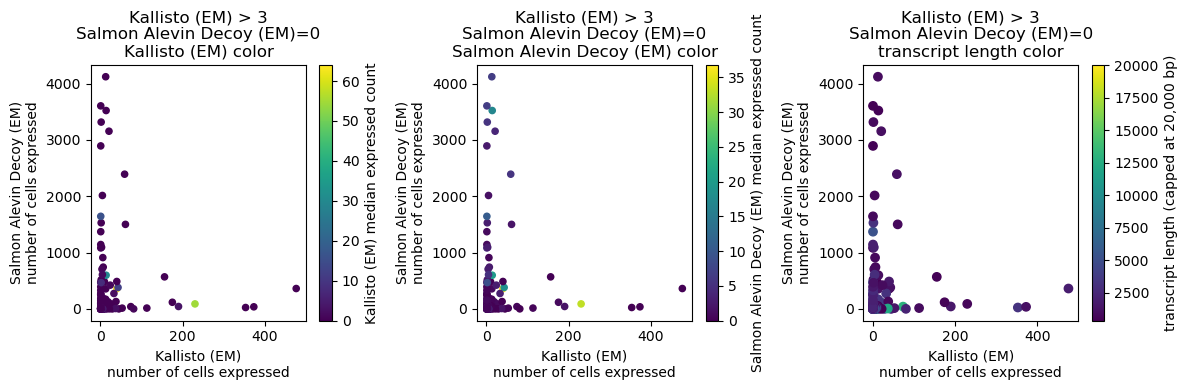

In [136]:
_ = plot_expressed_in_one(tenx_datasets, kallisto_em_name, alevin_decoy_name, 3, mm10_basic)
_

Expressed in just Kallisto (EM) 103
Expressed in just Salmon Alevin Decoy (EM) 103
Somtimes expressed in either (intersect) 19
All genes (union) 187
Index(['Kallisto (EM)', 'Salmon Alevin Decoy (EM)',
       'Kallisto (EM) median expressed count',
       'Salmon Alevin Decoy (EM) median expressed count'],
      dtype='object')


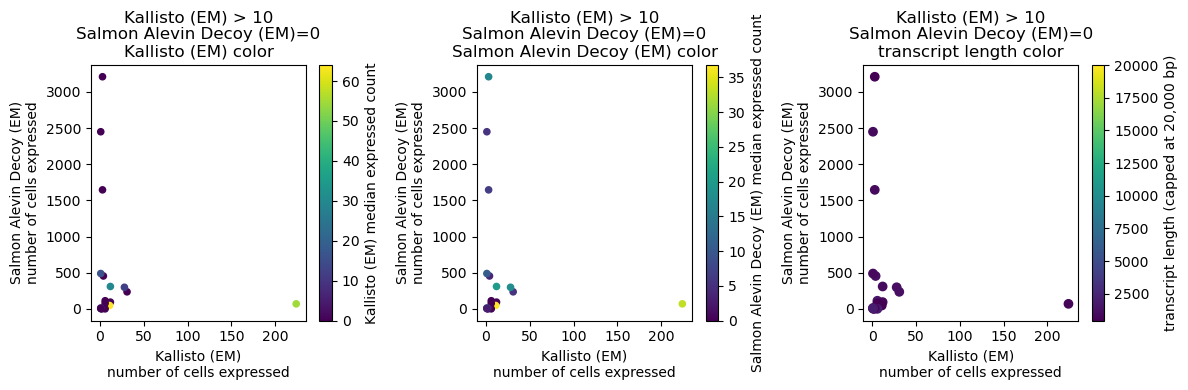

In [134]:
_ = plot_expressed_in_one(tenx_datasets, kallisto_em_name, alevin_decoy_name, 10, mm10_basic)
_

In [26]:
frequency = count_expressed_in_only_one(tenx_datasets, kallisto_em_name, alevin_decoy_name, 10)

gene_10count_in_kallisto_em = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[kallisto_em_name].dropna().index)) ][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_10count_in_kallisto_em['gene_base'] = gene_10count_in_kallisto_em['gene_id'].apply(lambda x: x.split('.')[0])
gene_10count_in_kallisto_em

Expressed in just Kallisto (EM) 103
Expressed in just Salmon Alevin Decoy (EM) 103
Somtimes expressed in either (intersect) 19
All genes (union) 187


,gene_id,gene_name,gene_type,feature_length,max_transcript_length,isoform_count,gene_base
56378,ENSMUSG00000054702.14,Ap1s3,protein_coding,65096,2871.0,1,ENSMUSG00000054702
72818,ENSMUSG00000056211.13,R3hdm1,protein_coding,134435,4768.0,2,ENSMUSG00000056211
100794,ENSMUSG00000097347.1,Gm17275,lincRNA,6915,2548.0,1,ENSMUSG00000097347
145743,ENSMUSG00000052371.5,Hoxd3os1,antisense,12882,1699.0,3,ENSMUSG00000052371
168489,ENSMUSG00000109528.2,Olfr1309,protein_coding,10424,5444.0,6,ENSMUSG00000109528
197417,ENSMUSG00000027636.11,Sla2,protein_coding,14735,2965.0,2,ENSMUSG00000027636
205300,ENSMUSG00000078923.10,Ube2v1,protein_coding,24457,2037.0,3,ENSMUSG00000078923
207899,ENSMUSG00000090625.1,Gm20721,protein_coding,16393,1471.0,1,ENSMUSG00000090625
216051,ENSMUSG00000100252.6,Mir124-2hg,lincRNA,19049,3843.0,7,ENSMUSG00000100252
222971,ENSMUSG00000058174.7,Gm5148,protein_coding,10300,1279.0,3,ENSMUSG00000058174


In [27]:
gene_10count_in_alevin_decoy = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[alevin_decoy_name].dropna().index))][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_10count_in_alevin_decoy['gene_base'] = gene_10count_in_alevin_decoy['gene_id'].apply(lambda x: x.split('.')[0])
gene_10count_in_alevin_decoy

,gene_id,gene_name,gene_type,feature_length,max_transcript_length,isoform_count,gene_base
33400,ENSMUSG00000026064.16,Ptp4a1,protein_coding,9007,4230.0,1,ENSMUSG00000026064
33418,ENSMUSG00000117310.1,Ptp4a1,protein_coding,9468,4139.0,3,ENSMUSG00000117310
65818,ENSMUSG00000026276.20,Sept2,protein_coding,31296,3766.0,1,ENSMUSG00000026276
76839,ENSMUSG00000094410.7,Gm38394,protein_coding,41378,10139.0,1,ENSMUSG00000094410
100752,ENSMUSG00000060743.12,H3f3a,protein_coding,13111,2837.0,3,ENSMUSG00000060743
116363,ENSMUSG00000078202.3,Nrarp,protein_coding,2581,2581.0,1,ENSMUSG00000078202
117904,ENSMUSG00000036504.6,Phpt1,protein_coding,1794,934.0,1,ENSMUSG00000036504
120534,ENSMUSG00000014852.16,Adamts13,protein_coding,36212,4477.0,2,ENSMUSG00000014852
177625,ENSMUSG00000074884.12,Serf2,protein_coding,9118,3053.0,3,ENSMUSG00000074884
179500,ENSMUSG00000035183.14,Slc24a5,protein_coding,20553,1945.0,1,ENSMUSG00000035183


In [28]:
gene_10count_in_both = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[kallisto_em_name].dropna().index)) & (mm10_basic['gene_id'].isin(frequency[alevin_decoy_name].dropna().index))][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_10count_in_both['gene_base'] = gene_10count_in_both['gene_id'].apply(lambda x: x.split('.')[0])
gene_10count_in_both

,gene_id,gene_name,gene_type,feature_length,max_transcript_length,isoform_count,gene_base
205300,ENSMUSG00000078923.10,Ube2v1,protein_coding,24457,2037.0,3,ENSMUSG00000078923
242222,ENSMUSG00000090733.6,Rps27,protein_coding,1129,453.0,3,ENSMUSG00000090733
274834,ENSMUSG00000068240.5,Gm11808,protein_coding,503,503.0,1,ENSMUSG00000068240
627289,ENSMUSG00000090137.8,Uba52,protein_coding,2538,707.0,6,ENSMUSG00000090137
627365,ENSMUSG00000055553.16,Kxd1,protein_coding,19684,1211.0,4,ENSMUSG00000055553
647693,ENSMUSG00000008450.8,Nutf2,protein_coding,18750,943.0,2,ENSMUSG00000008450
750429,ENSMUSG00000069622.4,Gm10273,protein_coding,1125,1125.0,1,ENSMUSG00000069622
851715,ENSMUSG00000020857.11,Nme2,protein_coding,6445,1007.0,2,ENSMUSG00000020857
851744,ENSMUSG00000091228.1,Gm20390,protein_coding,18474,983.0,1,ENSMUSG00000091228
883700,ENSMUSG00000078249.5,Hmga1b,protein_coding,1625,1625.0,2,ENSMUSG00000078249


In [29]:
gene_10count_in_kallisto_em['feature_length'].describe()

count       103.000000
mean      37729.941748
std       69443.543116
min         347.000000
25%        3652.000000
50%       12867.000000
75%       31390.000000
max      422531.000000
Name: feature_length, dtype: float64

In [30]:
gene_10count_in_alevin_decoy['feature_length'].describe()

count       103.000000
mean      16230.854369
std       20407.636420
min         373.000000
25%        2579.500000
50%        8895.000000
75%       22934.000000
max      119158.000000
Name: feature_length, dtype: float64

In [31]:
gene_10count_in_both['feature_length'].describe()

count       19.000000
mean      7866.157895
std       8704.563594
min        481.000000
25%       1012.500000
50%       2538.000000
75%      16927.000000
max      24457.000000
Name: feature_length, dtype: float64

In [32]:
gene_10count_in_kallisto_em['max_transcript_length'].describe()

count       103.000000
mean       5202.368932
std       15001.931886
min         347.000000
25%        1223.500000
50%        2523.000000
75%        4396.500000
max      123175.000000
Name: max_transcript_length, dtype: float64

In [33]:
gene_10count_in_alevin_decoy['max_transcript_length'].describe()

count      103.000000
mean      2323.650485
std       2228.622122
min        373.000000
25%        938.500000
50%       1789.000000
75%       3015.000000
max      17939.000000
Name: max_transcript_length, dtype: float64

In [34]:
gene_10count_in_both['max_transcript_length'].describe()

count      19.000000
mean      999.157895
std       473.242745
min       453.000000
25%       649.000000
50%       943.000000
75%      1188.500000
max      2037.000000
Name: max_transcript_length, dtype: float64

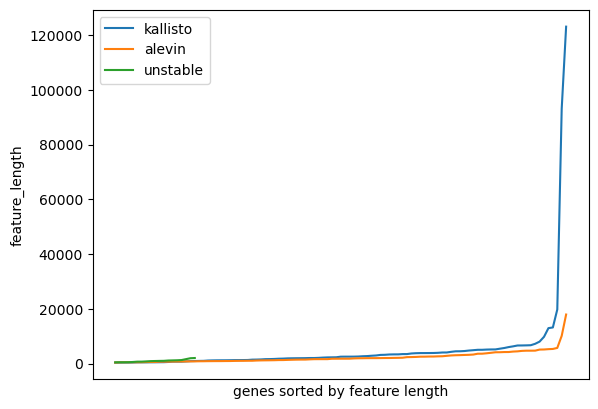

In [126]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.plot(range(gene_10count_in_kallisto_em['feature_length'].shape[0]), gene_10count_in_kallisto_em['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_10count_in_alevin_decoy['feature_length'].shape[0]), gene_10count_in_alevin_decoy['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_10count_in_both['feature_length'].shape[0]), gene_10count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by feature length')
ax.set_ylabel('feature_length')
ax.set_xticks([])
ax.legend()
f

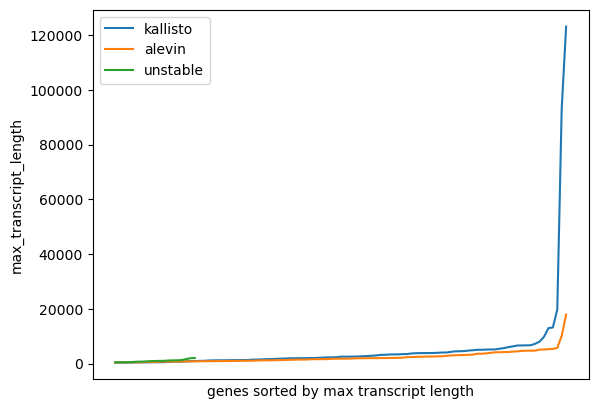

In [125]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.plot(range(gene_10count_in_kallisto_em['max_transcript_length'].shape[0]), gene_10count_in_kallisto_em['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_10count_in_alevin_decoy['max_transcript_length'].shape[0]), gene_10count_in_alevin_decoy['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_10count_in_both['max_transcript_length'].shape[0]), gene_10count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by max transcript length')
ax.set_ylabel('max_transcript_length')
ax.set_xticks([])
ax.legend()
f

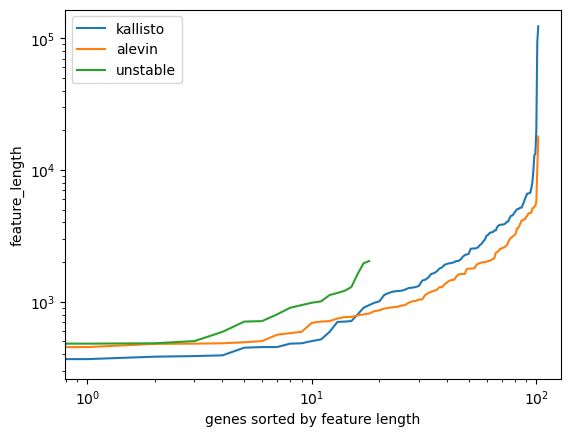

In [124]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.plot(range(gene_10count_in_kallisto_em['feature_length'].shape[0]), gene_10count_in_kallisto_em['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_10count_in_alevin_decoy['feature_length'].shape[0]), gene_10count_in_alevin_decoy['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_10count_in_both['feature_length'].shape[0]), gene_10count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by feature length')
ax.set_ylabel('feature_length')
ax.set_xticks([])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
f

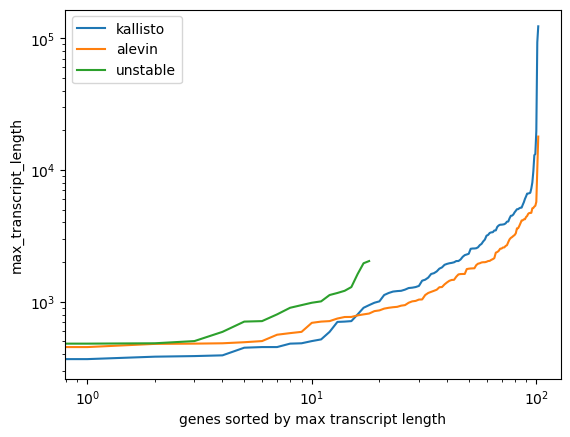

In [123]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.plot(range(gene_10count_in_kallisto_em['max_transcript_length'].shape[0]), gene_10count_in_kallisto_em['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_10count_in_alevin_decoy['max_transcript_length'].shape[0]), gene_10count_in_alevin_decoy['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_10count_in_both['max_transcript_length'].shape[0]), gene_10count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by max transcript length')
ax.set_ylabel('max_transcript_length')
ax.set_xticks([])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
f

In [39]:
gene_10count_in_both.columns

Index(['gene_id', 'gene_name', 'gene_type', 'feature_length',
       'max_transcript_length', 'isoform_count', 'gene_base'],
      dtype='object')

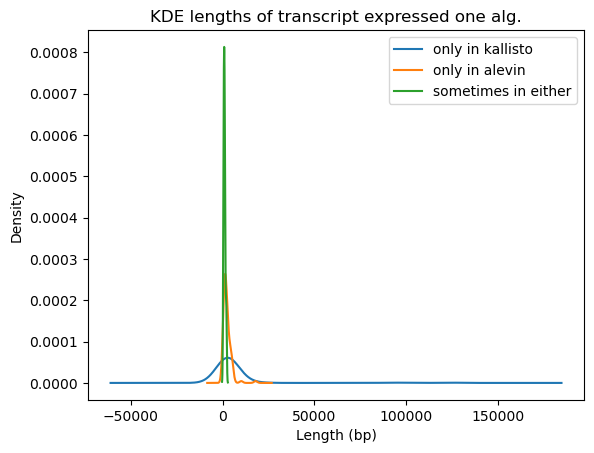

In [133]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('KDE lengths of transcript expressed one alg.')
gene_10count_in_kallisto_em['max_transcript_length'].plot.kde(ax=ax, label='only in kallisto')
gene_10count_in_alevin_decoy['max_transcript_length'].plot.kde(ax=ax, label='only in alevin')
gene_10count_in_both['max_transcript_length'].plot.kde(ax=ax, label='sometimes in either')
ax.set_xlabel('Length (bp)')
ax.legend()
f

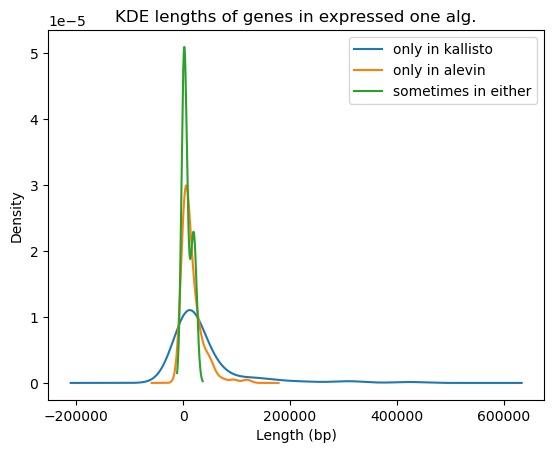

In [41]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('KDE lengths of genes in expressed one alg.')
gene_10count_in_kallisto_em['feature_length'].plot.kde(ax=ax, label='only in kallisto')
gene_10count_in_alevin_decoy['feature_length'].plot.kde(ax=ax, label='only in alevin')
gene_10count_in_both['feature_length'].plot.kde(ax=ax, label='sometimes in either')
ax.set_xlabel('Length (bp)')
ax.legend()
f

In [42]:
max_transcript_lengths = pandas.DataFrame({
    'kallisto': gene_10count_in_kallisto_em['max_transcript_length'],
    'alevin': gene_10count_in_alevin_decoy['max_transcript_length'],
    'both': gene_10count_in_both['max_transcript_length']
})

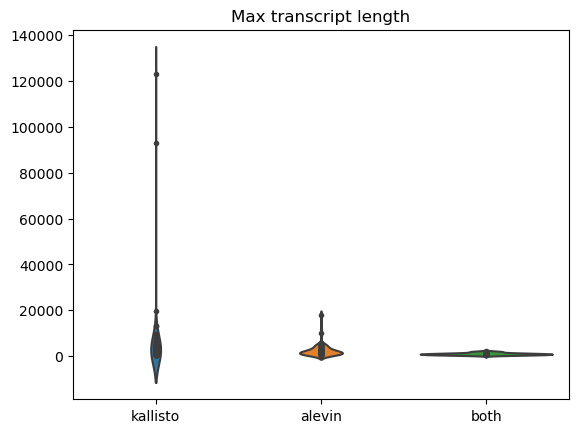

In [43]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Max transcript length')
seaborn.violinplot(data=max_transcript_lengths, inner='points', ax=ax)
f

In [44]:
max_gene_lengths = pandas.DataFrame({
    'kallisto': gene_10count_in_kallisto_em['feature_length'],
    'alevin': gene_10count_in_alevin_decoy['feature_length'],
    'both': gene_10count_in_both['feature_length']
})

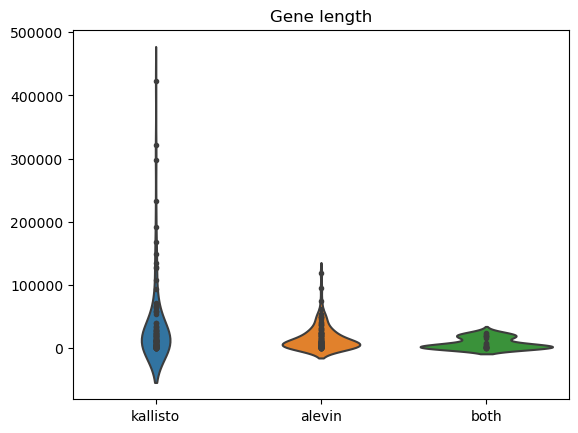

In [45]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Gene length')
seaborn.violinplot(data=max_gene_lengths, inner='points', ax=ax)
f

In [46]:
gene_10count_in_kallisto_em['isoform_count'].describe()

count    103.000000
mean       2.126214
std        1.557270
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: isoform_count, dtype: float64

In [47]:
gene_10count_in_alevin_decoy['isoform_count'].describe()

count    103.000000
mean       2.339806
std        2.427592
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       17.000000
Name: isoform_count, dtype: float64

In [48]:
gene_10count_in_both['isoform_count'].describe()

count    19.000000
mean      2.052632
std       1.352926
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       6.000000
Name: isoform_count, dtype: float64

In [49]:
counts = pandas.DataFrame({
    'kallisto': gene_10count_in_kallisto_em['isoform_count'],
    'alevin': gene_10count_in_alevin_decoy['isoform_count'],
    'both': gene_10count_in_both['isoform_count']
})

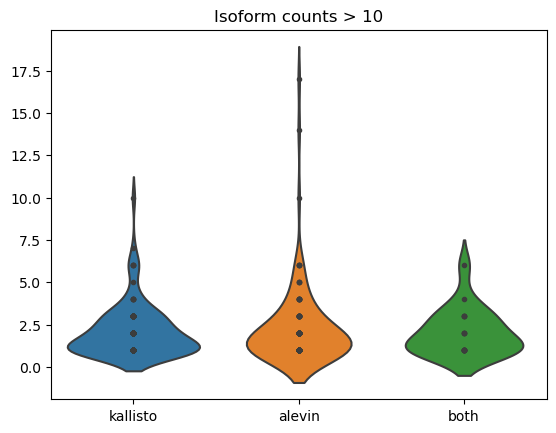

In [50]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Isoform counts > 10')
seaborn.violinplot(data=counts, inner='points', ax=ax)
f

In [51]:
protein_genes = mm10_basic[(mm10_basic['type'] == 'gene')&(mm10_basic['gene_type'] == 'protein_coding')]['gene_id']
protein_genes.head()

26254     ENSMUSG00000051951.5
26312    ENSMUSG00000025900.12
26410    ENSMUSG00000025902.13
26500    ENSMUSG00000033845.13
26547    ENSMUSG00000025903.14
Name: gene_id, dtype: object

In [52]:
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
        protein_genes, # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 81% 17,788 of 21,951 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 86% 18,806 of 21,951 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 80% 17,500 of 21,951 population items found in association


In [53]:
def generate_go_enrichment(goeaobj, geneids_study):
    goea_results_all = goeaobj.run_study(geneids_study.to_list())
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]
    return pandas.DataFrame([(x.GO, x.NS, x.name, x.p_fdr_bh) for x in goea_results_sig], columns=['GO_ID', "Process", "Name", "BH_FDR"])

In [54]:
kallisto_goe = generate_go_enrichment(
    goeaobj, 
    mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[kallisto_em_name].dropna().index))]['gene_id']
).sort_values(['BH_FDR'], ascending=True)
kallisto_goe


Run BP Gene Ontology Analysis: current study set of 103 IDs ... 86%     71 of     83 study items found in association
 81%     83 of    103 study items found in population(21951)
Calculating 12,392 uncorrected p-values using fisher_scipy_stats
  12,392 GO terms are associated with 17,734 of 21,951 population items
     455 GO terms are associated with     71 of    103 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 103 IDs ... 82%     68 of     83 study items found in association
 81%     83 of    103 study items found in population(21951)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with 18,806 of 21,951 population items
     137 GO terms are associated with     68 of 

,GO_ID,Process,Name,BH_FDR
0,GO:0005840,CC,ribosome,0.017674
2,GO:0003735,MF,structural constituent of ribosome,0.017831
1,GO:0022627,CC,cytosolic small ribosomal subunit,0.026037


In [55]:
alevin_goe = generate_go_enrichment(
    goeaobj, 
    mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[alevin_decoy_name].dropna().index))]['gene_id']
).sort_values(['BH_FDR'], ascending=True)
alevin_goe


Run BP Gene Ontology Analysis: current study set of 103 IDs ... 85%     87 of    102 study items found in association
 99%    102 of    103 study items found in population(21951)
Calculating 12,392 uncorrected p-values using fisher_scipy_stats
  12,392 GO terms are associated with 17,734 of 21,951 population items
     782 GO terms are associated with     87 of    103 study items
  METHOD fdr_bh:
       1 GO terms found significant (< 0.05=alpha) (  1 enriched +   0 purified): statsmodels fdr_bh
      13 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 103 IDs ... 90%     92 of    102 study items found in association
 99%    102 of    103 study items found in population(21951)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with 18,806 of 21,951 population items
     239 GO terms are associated with     92 of 

,GO_ID,Process,Name,BH_FDR
1,GO:0005840,CC,ribosome,7.665119e-10
26,GO:0003735,MF,structural constituent of ribosome,6.210720e-09
2,GO:0022625,CC,cytosolic large ribosomal subunit,5.105047e-07
0,GO:0006412,BP,translation,1.896049e-05
27,GO:0019899,MF,enzyme binding,1.767902e-04
3,GO:0005634,CC,nucleus,4.352198e-04
4,GO:0043209,CC,myelin sheath,7.006406e-04
5,GO:0022627,CC,cytosolic small ribosomal subunit,8.966690e-04
6,GO:0005744,CC,TIM23 mitochondrial import inner membrane tran...,1.554528e-03
28,GO:0061608,MF,nuclear import signal receptor activity,1.811777e-03


In [56]:
both_goe = generate_go_enrichment(
    goeaobj,
    mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency[kallisto_em_name].dropna().index)) & (mm10_basic['gene_id'].isin(frequency[alevin_decoy_name].dropna().index))]['gene_id']
).sort_values(['BH_FDR'], ascending=True)
both_goe


Run BP Gene Ontology Analysis: current study set of 19 IDs ... 89%     17 of     19 study items found in association
100%     19 of     19 study items found in population(21951)
Calculating 12,392 uncorrected p-values using fisher_scipy_stats
  12,392 GO terms are associated with 17,734 of 21,951 population items
      75 GO terms are associated with     17 of     19 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.05=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       9 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 19 IDs ... 89%     17 of     19 study items found in association
100%     19 of     19 study items found in population(21951)
Calculating 1,739 uncorrected p-values using fisher_scipy_stats
   1,739 GO terms are associated with 18,806 of 21,951 population items
      54 GO terms are associated with     17 of   

,GO_ID,Process,Name,BH_FDR
4,GO:0005840,CC,ribosome,0.001036
20,GO:0003735,MF,structural constituent of ribosome,0.001297
5,GO:0000125,CC,PCAF complex,0.005044
6,GO:0022627,CC,cytosolic small ribosomal subunit,0.005044
10,GO:0044613,CC,nuclear pore central transport channel,0.006325
7,GO:0005744,CC,TIM23 mitochondrial import inner membrane tran...,0.006325
8,GO:0070761,CC,pre-snoRNP complex,0.006325
9,GO:0022625,CC,cytosolic large ribosomal subunit,0.006325
12,GO:0030914,CC,STAGA complex,0.009005
11,GO:0000124,CC,SAGA complex,0.009005


In [57]:
with pandas.ExcelWriter("gene_10count_analysis.xlsx") as out:
    gene_10count_in_kallisto_em.to_excel(out, sheet_name="Expressed in Kallisto", index=False)
    gene_10count_in_alevin_decoy.to_excel(out, sheet_name="Expressed in Alevin", index=False)
    gene_10count_in_both.to_excel(out, sheet_name="Expressed in Either", index=False)
    kallisto_goe.to_excel(out, sheet_name="GO Enrichment in Kallisto", index=False)
    alevin_goe.to_excel(out, sheet_name="GO Enrichment in Alevin", index=False)
    both_goe.to_excel(out, sheet_name="GO Enrichment in Either", index=False)

# Try with threshold = 3

In [58]:

frequency3 = count_expressed_in_only_one(tenx_datasets, kallisto_em_name, alevin_decoy_name, 3)

kallisto_expressed = frequency3[kallisto_em_name].index
alevin_expressed = frequency3[alevin_decoy_name].index

kallisto_expressed_median = tenx_datasets[kallisto_em_name].loc[kallisto_expressed][tenx_datasets[kallisto_em_name].loc[kallisto_expressed] > 0].median(axis=1)
alevin_expressed_median = tenx_datasets[alevin_decoy_name].loc[alevin_expressed][tenx_datasets[alevin_decoy_name].loc[alevin_expressed] > 0].median(axis=1)

kallisto_expressed_max = tenx_datasets[kallisto_em_name].loc[kallisto_expressed][tenx_datasets[kallisto_em_name].loc[kallisto_expressed] > 0].max(axis=1)
alevin_expressed_max = tenx_datasets[alevin_decoy_name].loc[alevin_expressed][tenx_datasets[alevin_decoy_name].loc[alevin_expressed] > 0].max(axis=1)

frequency3.update({
    'kallisto_em_median': kallisto_expressed_median,
    'alevin_median': alevin_expressed_median,
    'kallisto_em_max': kallisto_expressed_max,
    'alevin_max': alevin_expressed_max,
})
frequency.shape


gene_3count_in_kallisto = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency3[kallisto_em_name].dropna().index))][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_3count_in_kallisto['gene_base'] = gene_3count_in_kallisto['gene_id'].apply(lambda x: x.split('.')[0])
gene_3count_in_kallisto

gene_3count_in_alevin = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency3[alevin_decoy_name].dropna().index))][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_3count_in_alevin['gene_base'] = gene_3count_in_alevin['gene_id'].apply(lambda x: x.split('.')[0])
gene_3count_in_alevin

gene_3count_in_both = mm10_basic[(mm10_basic['type'] == 'gene') & (mm10_basic['gene_id'].isin(frequency3[kallisto_em_name].dropna().index)) & (mm10_basic['gene_id'].isin(frequency[alevin_decoy_name].dropna().index))][['gene_id', 'gene_name', 'gene_type', 'feature_length', 'max_transcript_length', 'isoform_count']]
gene_3count_in_both['gene_base'] = gene_3count_in_both['gene_id'].apply(lambda x: x.split('.')[0])
gene_3count_in_both


lengths3 = pandas.DataFrame({
    'kallisto': gene_3count_in_kallisto['feature_length'],
    'alevin': gene_3count_in_alevin['feature_length'],
    'both': gene_3count_in_both['feature_length']
})

transcript_lengths3 = pandas.DataFrame({
    'kallisto': gene_3count_in_kallisto['max_transcript_length'],
    'alevin': gene_3count_in_alevin['max_transcript_length'],
    'both': gene_3count_in_both['max_transcript_length']
})

counts3 = pandas.DataFrame({
    'kallisto_em': gene_3count_in_kallisto['isoform_count'],
    'alevin_decoy': gene_3count_in_alevin['isoform_count'],
    'both': gene_3count_in_both['isoform_count']
})

Expressed in just Kallisto (EM) 1851
Expressed in just Salmon Alevin Decoy (EM) 594
Somtimes expressed in either (intersect) 142
All genes (union) 2303


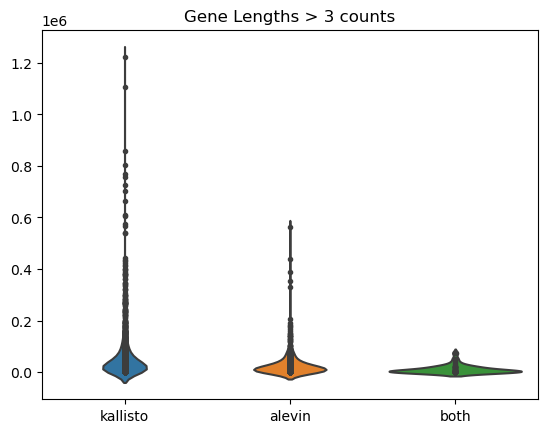

In [116]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Gene Lengths > 3 counts')
seaborn.violinplot(data=lengths3, inner='points', ax=ax)
f

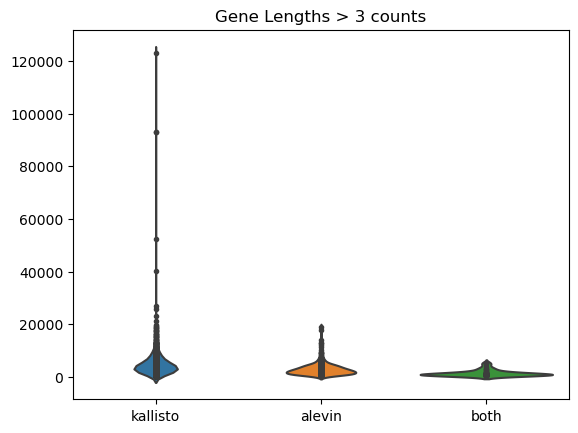

In [117]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Gene Lengths > 3 counts')
seaborn.violinplot(data=transcript_lengths3, inner='points', ax=ax)
f

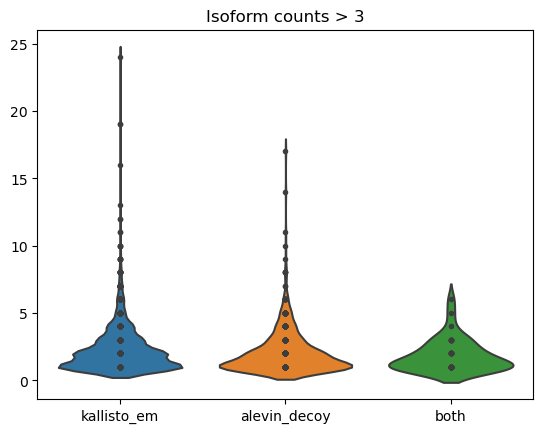

In [118]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('Isoform counts > 3')
seaborn.violinplot(data=counts3, inner='points', ax=ax)
f

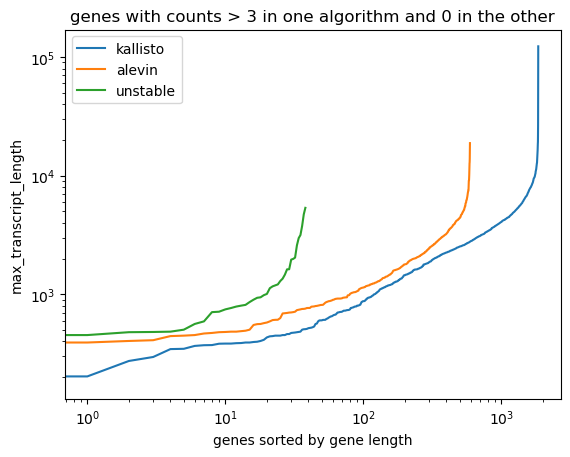

In [119]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('genes with counts > 3 in one algorithm and 0 in the other')
ax.plot(range(gene_3count_in_kallisto['feature_length'].shape[0]), gene_3count_in_kallisto['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_3count_in_alevin['feature_length'].shape[0]), gene_3count_in_alevin['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_3count_in_both['feature_length'].shape[0]), gene_3count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by gene length')
ax.set_ylabel('max_transcript_length')
ax.set_xticks([])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
f

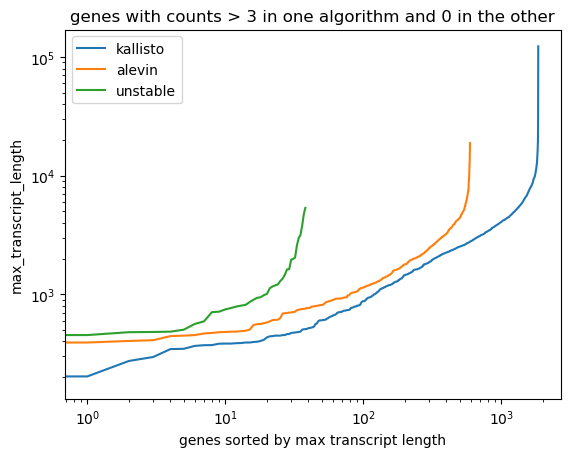

In [120]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
ax.set_title('genes with counts > 3 in one algorithm and 0 in the other')
ax.plot(range(gene_3count_in_kallisto['max_transcript_length'].shape[0]), gene_3count_in_kallisto['max_transcript_length'].sort_values(), label='kallisto')
ax.plot(range(gene_3count_in_alevin['max_transcript_length'].shape[0]), gene_3count_in_alevin['max_transcript_length'].sort_values(), label='alevin')
ax.plot(range(gene_3count_in_both['max_transcript_length'].shape[0]), gene_3count_in_both['max_transcript_length'].sort_values(), label='unstable')
ax.set_xlabel('genes sorted by max transcript length')
ax.set_ylabel('max_transcript_length')
ax.set_xticks([])
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
f

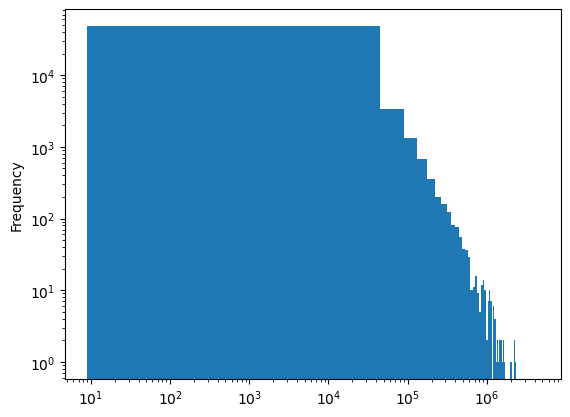

In [121]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
mm10_basic[mm10_basic['type']=='gene']['feature_length'].plot.hist(ax=ax, bins=100)
ax.set_xscale('log')
ax.set_yscale('log')
f

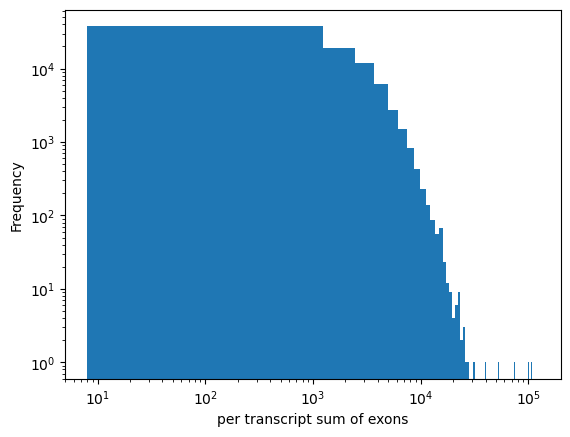

In [122]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)
mm10_basic[mm10_basic['type']=='transcript']['transcript_length'].plot.hist(ax=ax, bins=100)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('per transcript sum of exons')
f

In [66]:
mm10_basic[(mm10_basic['type']=='transcript')& (mm10_basic['transcript_length'] < 2000)]['transcript_length'].plot.hist(bins=100)

<AxesSubplot:xlabel='per transcript sum of exons', ylabel='Frequency'>

In [67]:
mm10_basic[(mm10_basic['type']=='transcript')& (mm10_basic['transcript_length'] >= 2000) & (mm10_basic['transcript_length'] < 20000)]['transcript_length'].plot.hist(bins=100)

<AxesSubplot:xlabel='per transcript sum of exons', ylabel='Frequency'>

In [68]:
mm10_basic[(mm10_basic['type']=='transcript')& (mm10_basic['transcript_length'] >= 20000)]['transcript_length'].plot.hist(bins=100)

<AxesSubplot:xlabel='per transcript sum of exons', ylabel='Frequency'>

In [69]:
mm10_basic.set_index('gene_id')['isoform_count'].idxmax()

'ENSMUSG00000052613.16'

In [70]:
count, widths = numpy.histogram(mm10_basic['max_transcript_length'].dropna())

In [71]:
list(zip(widths[0:-1], widths[1:]))

[(8.0, 12324.7),
 (12324.7, 24641.4),
 (24641.4, 36958.100000000006),
 (36958.100000000006, 49274.8),
 (49274.8, 61591.5),
 (61591.5, 73908.20000000001),
 (73908.20000000001, 86224.90000000001),
 (86224.90000000001, 98541.6),
 (98541.6, 110858.3),
 (110858.3, 123175.0)]

In [72]:
short_transcripts = mm10_basic.loc[mm10_basic['max_transcript_length'].dropna().sort_values()[:500].index]['gene_id']

In [73]:
long_transcripts = mm10_basic.loc[mm10_basic['max_transcript_length'].dropna().sort_values()[-500:].index]['gene_id']

In [74]:
tenx_datasets[kallisto_em_name].reindex(long_transcripts.values).sum()

CCGGTAGCAGCCTTGG    241.215546
AGCGGTCAGGTGCTTT    229.488571
TCGAGGCCAGCCTTGG    498.562317
AGACGTTTCGTTGCCT    206.258575
GGGATGATCTCATTCA    246.734604
                       ...    
CATCGGGCACGGTAGA    262.007721
GTCGGGTAGGAGTAGA    211.791580
TCAATCTTCTCCAGGG    192.257462
TAGGCATGTCTCACCT    201.644638
AAATGCCCACTGTCGG    561.783447
Length: 6289, dtype: float32

In [75]:
tenx_datasets[alevin_decoy_name].reindex(long_transcripts.values).sum()

CCGGTAGCAGCCTTGG    196.664825
AGCGGTCAGGTGCTTT    201.938599
TCGAGGCCAGCCTTGG    429.190491
AGACGTTTCGTTGCCT    147.000000
GGGATGATCTCATTCA    188.635590
                       ...    
CATCGGGCACGGTAGA    211.000000
GTCGGGTAGGAGTAGA    190.529419
TCAATCTTCTCCAGGG    156.396820
TAGGCATGTCTCACCT    151.037048
AAATGCCCACTGTCGG    471.656982
Length: 6289, dtype: float32

In [76]:
tenx_datasets[kallisto_em_name].reindex(short_transcripts.values).sum().sum()

5.0

In [77]:
short_alevin_decoy = tenx_datasets[alevin_decoy_name].reindex(short_transcripts.values).sum()
short_alevin_decoy[short_alevin_decoy > 0]

Series([], dtype: float32)

In [78]:
kallisto_em_short = tenx_datasets[kallisto_em_name].reindex(short_transcripts.values).unstack().dropna()
kallisto_em_short[kallisto_em_short > 0]


TTCGGTCAGACAATAC  ENSMUSG00000076902.1    1.0
TGCTGCTCAGTTTACG  ENSMUSG00000076887.1    1.0
AGGTCCGGTCTAACGT  ENSMUSG00000079039.1    1.0
TGGCTGGAGCCGCCTA  ENSMUSG00000076884.1    1.0
ATCTACTTCGTTGCCT  ENSMUSG00000079039.1    1.0
dtype: float32

In [79]:
mm10_basic[mm10_basic['gene_id'].isin(short_transcripts.values)][['gene_id', 'gene_name', 'feature_length', 'max_transcript_length']]

,gene_id,gene_name,feature_length,max_transcript_length
96,4833,NaN,61,61.0
1064,45350,NaN,61,61.0
1359,51050,NaN,63,63.0
3499,62142,NaN,63,63.0
4101,20904,NaN,61,61.0
...,...,...,...,...
1299997,ENSMUSG00000106618.1,Gm47281,59,NaN
1299998,ENSMUSG00000106618.1,Gm47281,59,NaN
1310860,ENSMUSG00000064365.1,mt-Ts2,58,58.0
1310861,ENSMUSG00000064365.1,mt-Ts2,58,NaN


In [80]:
kallisto_em_long = tenx_datasets[kallisto_em_name].reindex(long_transcripts.values).unstack().dropna()
kallisto_em_long[kallisto_em_long > 0]


CCGGTAGCAGCCTTGG  ENSMUSG00000045210.8      1.00000
                  ENSMUSG00000016756.17     1.00000
                  ENSMUSG00000022914.17     1.00000
                  ENSMUSG00000030102.11     1.00000
                  ENSMUSG00000041415.10     1.00000
                                             ...   
AAATGCCCACTGTCGG  ENSMUSG00000044768.16     1.00962
                  ENSMUSG00000089940.1      2.52132
                  ENSMUSG00000101609.2      8.88778
                  ENSMUSG00000115801.1      2.24466
                  ENSMUSG00000020255.8     14.68430
Length: 748310, dtype: float32

In [81]:
alevin_decoy_short = tenx_datasets[alevin_decoy_name].reindex(short_transcripts.values).unstack().dropna()
alevin_decoy_short[alevin_decoy_short > 0]


Series([], dtype: float32)

In [82]:
alevin_decoy_long = tenx_datasets[alevin_decoy_name].reindex(long_transcripts.values).unstack().dropna()
alevin_decoy_long[alevin_decoy_long > 0]


CCGGTAGCAGCCTTGG  ENSMUSG00000045210.8     1.0
                  ENSMUSG00000022914.17    1.0
                  ENSMUSG00000030102.11    1.0
                  ENSMUSG00000041415.10    1.0
                  ENSMUSG00000028080.16    1.0
                                          ... 
AAATGCCCACTGTCGG  ENSMUSG00000066037.14    8.0
                  ENSMUSG00000026131.18    1.0
                  ENSMUSG00000028649.18    1.0
                  ENSMUSG00000101609.2     8.0
                  ENSMUSG00000020255.8     1.0
Length: 638488, dtype: float32

In [83]:

def bin_length_quantification(table, gtf, bins=None):
    """Bin a library quantification file

    default bins are [0.1, 1, 2, 5, 10, 50, 500, 5000, 1e9]
    """
    if bins is None:
        bins = [0.1, 1, 2, 5, 10, 50, 500, 5000, 1e9]

    histogram = {}
    for low, high in [(0,200),(200,400),(400,600),(600,800),(800,1000),(40000,50000),(50000,60000),(60000,70000),(70000,80000),(80000,1e6)]:
        length_filter = (gtf['max_transcript_length'] >= low) & (gtf['max_transcript_length'] < high)
        gene_ids = gtf[length_filter]['gene_id']
        if len(gene_ids.values) > 0:
            counts = table.reindex(gene_ids.values).unstack().dropna()
            histogram["[{}-{})".format(low,high)], _ = numpy.histogram(counts, bins)
        else:
            histogram["[{}-{})".format(low,high)] = 0

    histogram = pandas.DataFrame(
        histogram,
    #    columns=quantification.columns,
        index=['{} {}'.format(x, 'count') for x in bins[:-1]])

    return histogram.reindex(histogram.index[::-1]).T


In [84]:
bin_length_quantification(tenx_datasets[kallisto_em_name], mm10_basic)

,5000 count,500 count,50 count,10 count,5 count,2 count,1 count,0.1 count
[0-200),0,0,0,0,1,311,1916,0
[200-400),0,0,3566,17038,8158,10161,18839,0
[400-600),0,93,52838,107890,72995,85904,88132,0
[600-800),50,398,91366,156118,147130,240043,211284,0
[800-1000),0,40,87607,155961,198099,377131,296871,0
[40000-50000),0,0,0,0,10,614,1586,0
[50000-60000),0,0,0,0,52,1271,1519,0
[60000-70000),0,0,0,0,0,0,0,0
[70000-80000),0,0,0,0,0,0,0,0
[80000-1000000.0),0,0,0,1416,5005,6397,2335,0


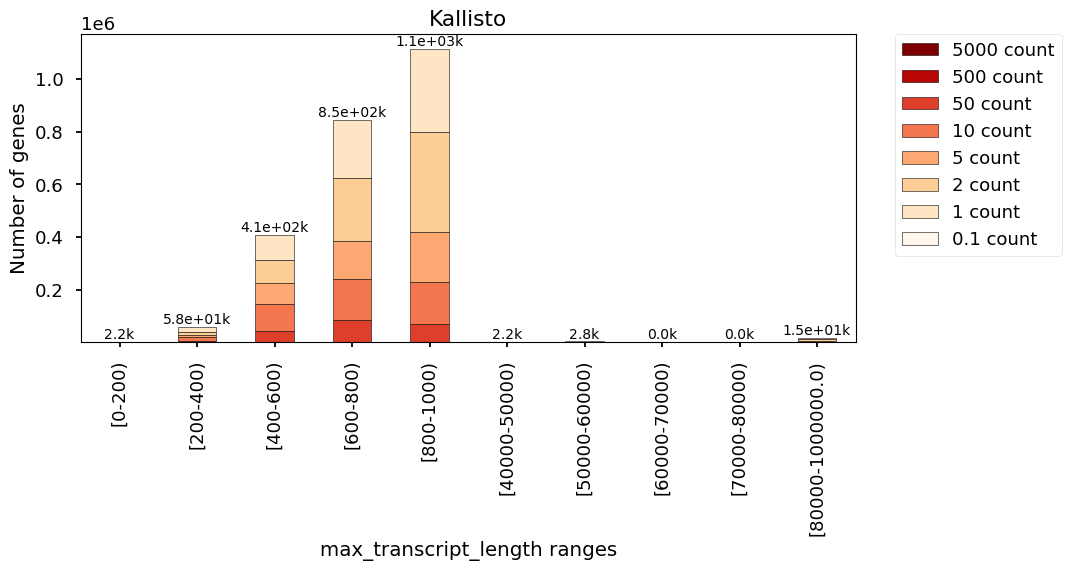

In [127]:
_ = plot_gene_detection_histogram(bin_length_quantification(tenx_datasets[kallisto_name], mm10_basic), "Kallisto", show_genes_detected=True, figsize=(10,4))
_.axes[0].set_xlabel('max_transcript_length ranges')
_

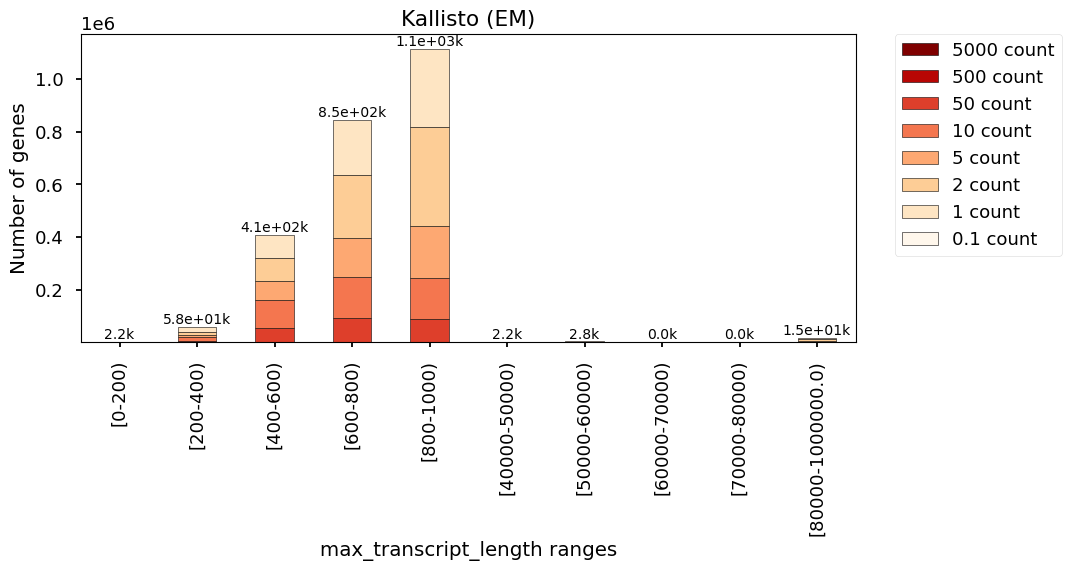

In [128]:
_ = plot_gene_detection_histogram(bin_length_quantification(tenx_datasets[kallisto_em_name], mm10_basic), "Kallisto (EM)", show_genes_detected=True, figsize=(10,4))
_.axes[0].set_xlabel('max_transcript_length ranges')
_

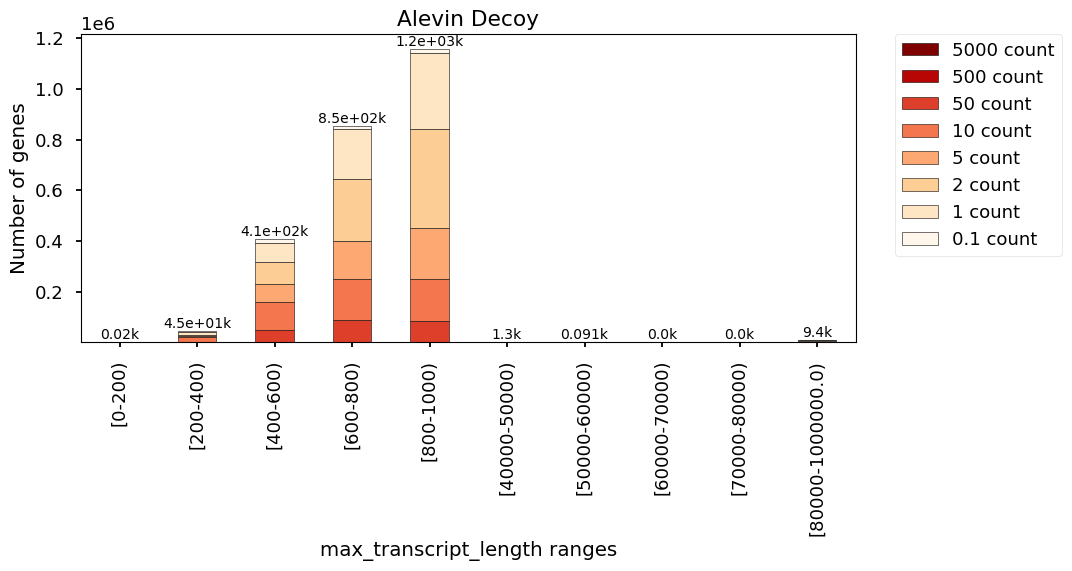

In [129]:
_ = plot_gene_detection_histogram(bin_length_quantification(tenx_datasets[alevin_decoy_name], mm10_basic), "Alevin Decoy", show_genes_detected=True, figsize=(10,4))
_.axes[0].set_xlabel('max_transcript_length ranges')
_

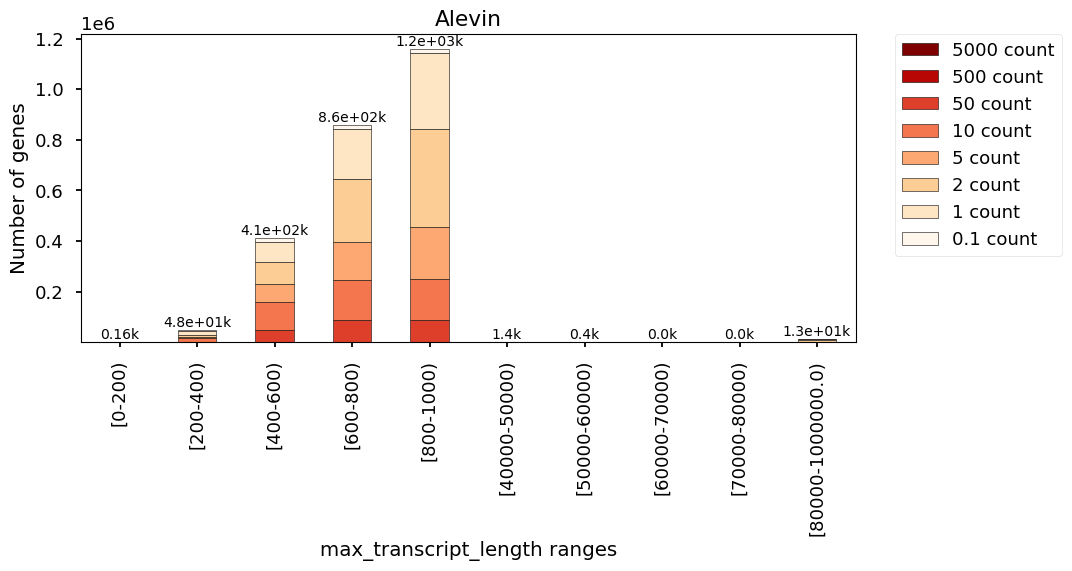

In [130]:
_ = plot_gene_detection_histogram(bin_length_quantification(tenx_datasets[alevin_name], mm10_basic), "Alevin", show_genes_detected=True, figsize=(10,4))
_.axes[0].set_xlabel('max_transcript_length ranges')
_

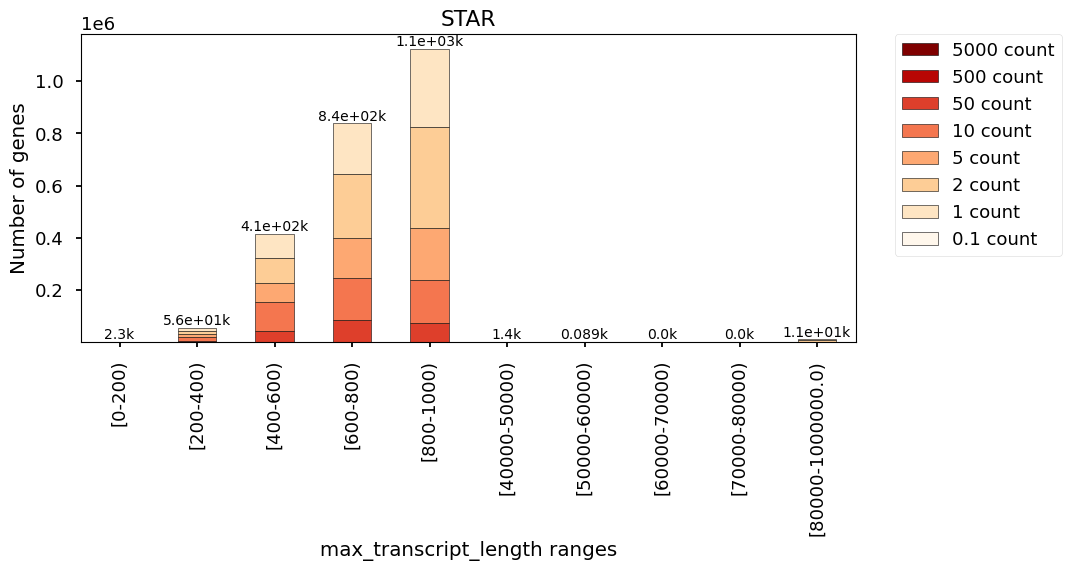

In [131]:
_ = plot_gene_detection_histogram(bin_length_quantification(tenx_datasets[star_name], mm10_basic), "STAR", show_genes_detected=True, figsize=(10,4))
_.axes[0].set_xlabel('max_transcript_length ranges')
_

In [90]:
mm10_basic[mm10_basic['gene_id']=='ENSMUSG00000020255.8']

,chromosome,source,type,start,stop,score,strand,frame,gene_id,transcript_id,...,havana_transcript,exon_number,exon_id,protein_id,ccdsid,ont,feature_length,transcript_length,max_transcript_length,isoform_count
771998,chr10,HAVANA,gene,83360221,83488505,NaN,1,NaN,ENSMUSG00000020255.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,128284,NaN,123175.0,1
771999,chr10,HAVANA,transcript,83360221,83488505,NaN,1,NaN,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,NaN,NaN,ENSMUSP00000020488.7,CCDS24076.1,NaN,128284,123175.0,NaN,1
772000,chr10,HAVANA,exon,83360221,83360373,NaN,1,NaN,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,1.0,ENSMUSE00000295211.7,ENSMUSP00000020488.7,CCDS24076.1,NaN,152,NaN,NaN,1
772001,chr10,HAVANA,CDS,83360259,83360373,NaN,1,0.0,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,1.0,ENSMUSE00000295211.7,ENSMUSP00000020488.7,CCDS24076.1,NaN,114,NaN,NaN,1
772002,chr10,HAVANA,start_codon,83360259,83360261,NaN,1,0.0,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,1.0,ENSMUSE00000295211.7,ENSMUSP00000020488.7,CCDS24076.1,NaN,2,NaN,NaN,1
772003,chr10,HAVANA,exon,83362047,83362133,NaN,1,NaN,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,2.0,ENSMUSE00000382852.2,ENSMUSP00000020488.7,CCDS24076.1,NaN,86,NaN,NaN,1
772004,chr10,HAVANA,CDS,83362047,83362133,NaN,1,2.0,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,2.0,ENSMUSE00000382852.2,ENSMUSP00000020488.7,CCDS24076.1,NaN,86,NaN,NaN,1
772005,chr10,HAVANA,exon,83364379,83364515,NaN,1,NaN,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,3.0,ENSMUSE00000426306.1,ENSMUSP00000020488.7,CCDS24076.1,NaN,136,NaN,NaN,1
772006,chr10,HAVANA,CDS,83364379,83364515,NaN,1,2.0,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,3.0,ENSMUSE00000426306.1,ENSMUSP00000020488.7,CCDS24076.1,NaN,136,NaN,NaN,1
772007,chr10,HAVANA,exon,83365704,83488505,NaN,1,NaN,ENSMUSG00000020255.8,ENSMUST00000020488.8,...,OTTMUST00000148258.1,4.0,ENSMUSE00000368086.4,ENSMUSP00000020488.7,CCDS24076.1,NaN,122801,NaN,NaN,1


In [91]:
def plot_long_transcripts(datasets, left_name, right_name, gtf):
    length_filter = (gtf['max_transcript_length'] >= 120_000)
    gene_ids = gtf[length_filter]['gene_id']
    #print('gene_ids', gene_ids.shape)
    left = datasets[left_name]
    right = datasets[right_name]
    left_long = left.reindex(gene_ids.values).unstack().dropna()
    right_long = right.reindex(gene_ids.values).unstack().dropna()
    #print(right_long.shape, right_long.shape)
    
    f = pyplot.figure(figsize=(8,8))
    gs = f.add_gridspec(2, 2)
    
    ax = f.add_subplot(gs[1,0])
    ax.scatter(left_long, right_long, s=2)
    ax.set_xlabel(left_name)
    ax.set_ylabel(right_name)
    
    ax = f.add_subplot(gs[0,0])
    ax.hist(left_long, bins=100)
    ax.set_xlabel(left_name)
    
    ax = f.add_subplot(gs[1,1])
    ax.hist(right_long, bins=100, orientation="horizontal")
    ax.set_xlabel(right_name)    
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    return f


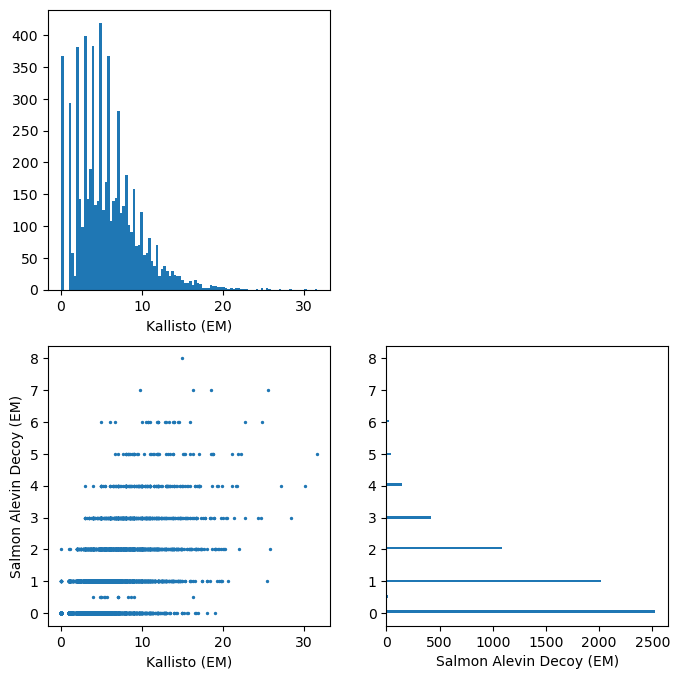

In [132]:
f = plot_long_transcripts(tenx_datasets, kallisto_em_name, alevin_decoy_name, mm10_basic)
f

In [93]:
def plot_one_gene(datasets, left_name, right_name, *, gene_id=None, gtf=None, gene_name=None):
    if gene_id is None:
        if gtf is None and gene_name is None:
            raise ValueError("Please specify either gene_id or a gtf and gene name")
        else:
            gene_id = gtf[gtf['gene_name'] == gene_name]['gene_id'].unique()[0]
    
    left = datasets[left_name]
    right = datasets[right_name]
    left_long = left.loc[gene_id]
    print(left_name, left_long[left_long>0].count())
    right_long = right.loc[gene_id]
    print(right_name, right_long[right_long>0].count())
    counts = pandas.merge(left_long, right_long, left_index=True, right_index=True)
    counts.columns = [left_name, right_name]
    series, (resid, rank, sv, rcond) = numpy.polynomial.polynomial.Polynomial.fit(counts[left_name], counts[right_name], deg=1, full=True)

    
    f = pyplot.figure(figsize=(6,6))
    gs = f.add_gridspec(3, 3)
    ax_scatter = f.add_subplot(gs[1:3,0:2])
    counts.plot.scatter(x=left_name, y=right_name, ax=ax_scatter, s=1)
    #ax.set_title("{} expressed genes".format(counts[counts > 0].dropna(axis=0, how='any').shape[0]))
    ax_scatter.plot([counts.min(),counts.max()],[counts.min(),counts.max()], color='r', alpha=.5)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax_scatter.grid(axis='both', alpha=0.5)
    ax_scatter.set_xlabel(left_name)
    ax_scatter.set_ylabel(right_name)
    
    ax = f.add_subplot(gs[0,0:2], sharex=ax_scatter)
    #ax.set_title('{} expressed'.format(left_name))
    ax.hist(left_long, bins=10)
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(axis='both', alpha=0.5)
    #ax.set_xticks([])
    #ax.set_xlabel("Counts")
    #ax.set_ylabel("Frequency")
    
    ax = f.add_subplot(gs[1:3,2], sharey=ax_scatter)
    #ax.set_title('{} expressed'.format(right_name))
    ax.hist(right_long, bins=10, orientation="horizontal")
    #ax.set_xlabel("Counts")
    #ax.set_ylabel("Frequency")
    ax.set_xscale('log')
    ax.grid(axis='both', alpha=0.5)
    #ax.set_yscale('log')
    return f


Kallisto (EM) 5056
Salmon Alevin Decoy (EM) 5044
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


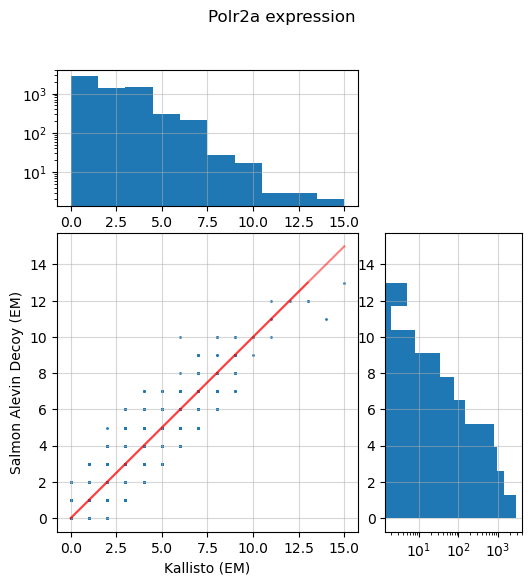

In [105]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Polr2a")
_ = f.suptitle("Polr2a expression")
f

Kallisto (EM) 686
Salmon Alevin Decoy (EM) 674


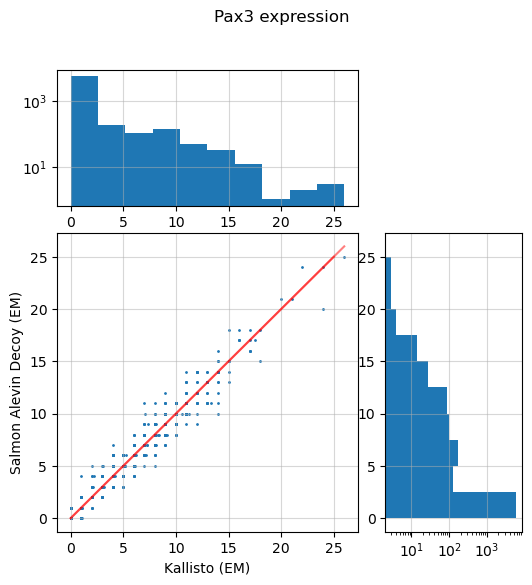

In [106]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Pax3")
_ = f.suptitle("Pax3 expression")
f

Kallisto (EM) 126
Salmon Alevin Decoy (EM) 123


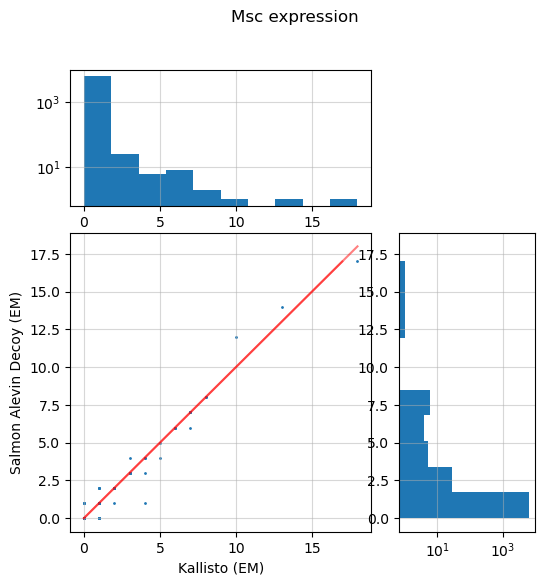

In [107]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Msc")
_ = f.suptitle("Msc expression")
f

Kallisto (EM) 11
Salmon Alevin Decoy (EM) 11


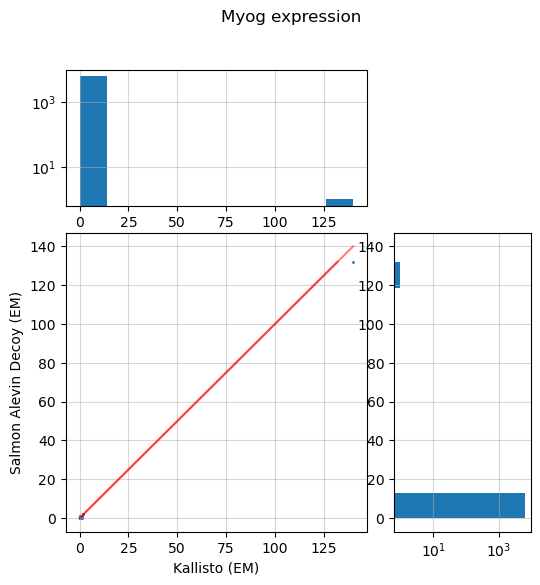

In [108]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Myog")
_ = f.suptitle("Myog expression")
f

Kallisto (EM) 6
Salmon Alevin Decoy (EM) 6


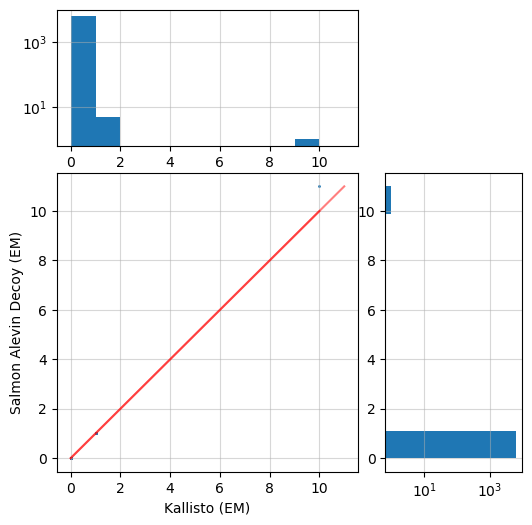

In [109]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Myod1")
f

Kallisto (EM) 3312
Salmon Alevin Decoy (EM) 4676


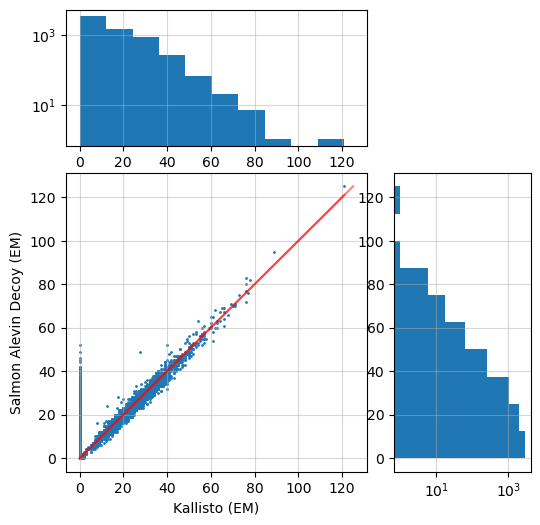

In [110]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Xist")
f

Kallisto (EM) 3312
STAR Solo 4721


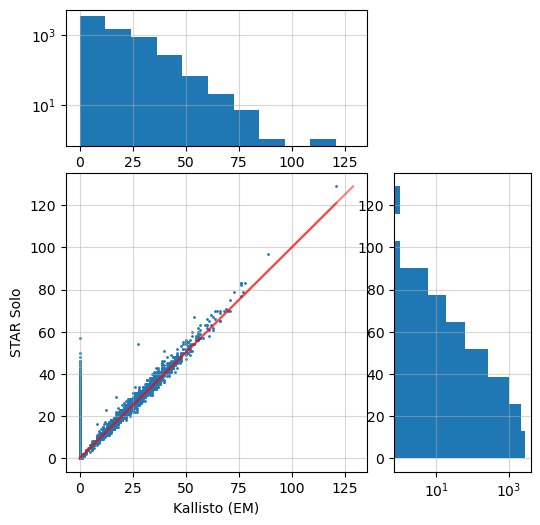

In [111]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, star_name, gtf=mm10_basic, gene_name="Xist")
f

STAR Solo 4721
Salmon Alevin Decoy (EM) 4676


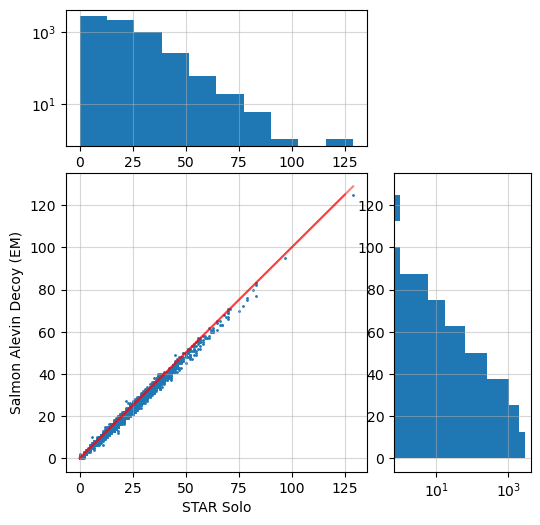

In [112]:
f = plot_one_gene(tenx_datasets, star_name, alevin_decoy_name, gtf=mm10_basic, gene_name="Xist")
f

Kallisto (EM) 5917
Salmon Alevin Decoy (EM) 4996


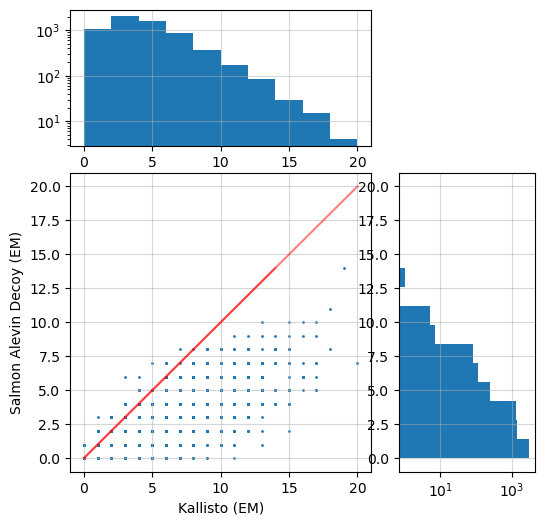

In [113]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, alevin_decoy_name, gtf=mm10_basic, gene_name="mt-Nd3")
f

Kallisto (EM) 5917
STAR Solo 5919


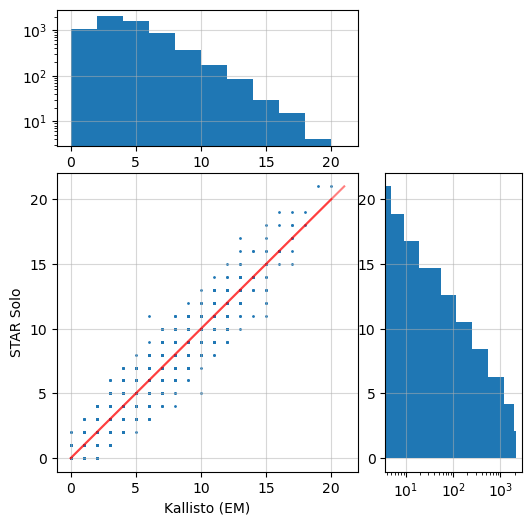

In [114]:
f = plot_one_gene(tenx_datasets, kallisto_em_name, star_name, gtf=mm10_basic, gene_name="mt-Nd3")
f

STAR Solo 5919
Salmon Alevin Decoy (EM) 4996


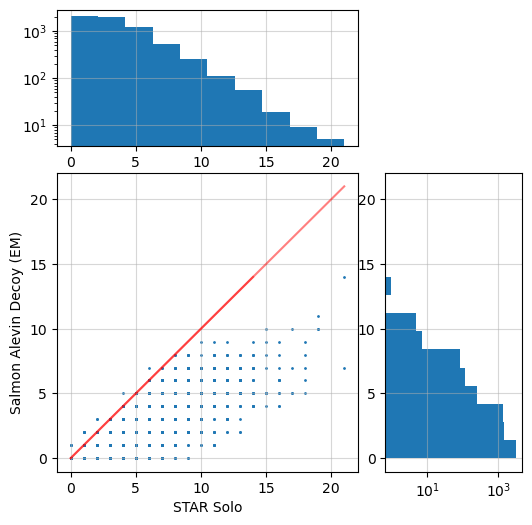

In [115]:
f = plot_one_gene(tenx_datasets, star_name, alevin_decoy_name, gtf=mm10_basic, gene_name="mt-Nd3")
f